In [80]:
import os
import sys

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../')
os.getcwd()

'/home/lehl/development/QueryOptDeepDive'

In [ ]:
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload')

In [200]:
import time

In [207]:
exec.execute('SET enable_bao TO ' + str(True))
exec.execute('SET enable_bao_selection TO ' + str(True))
exec.execute('SET enable_bao_rewards TO ' + str(False))
start = time.time()
cur = exec.execute("""
    EXPLAIN (ANALYZE, VERBOSE, FORMAT JSON)
   SELECT MIN(mc.note) AS production_note,
   MIN(t.title) AS movie_title,
   MIN(t.production_year) AS movie_year
FROM company_type AS ct,
 info_type AS it,
 movie_companies AS mc,
 movie_info_idx AS mi_idx,
 title AS t
WHERE ct.kind = 'production companies'
AND it.info = 'top 250 rank'
AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%'
AND (mc.note LIKE '%(co-production)%'
   OR mc.note LIKE '%(presents)%')
AND ct.id = mc.company_type_id
AND t.id = mc.movie_id
AND t.id = mi_idx.movie_id
AND mc.movie_id = mi_idx.movie_id
AND it.id = mi_idx.info_type_id;

""")
result = cur.fetchall()
time_taken = time.time() - start

print(result[0][0][-1]['Execution Time'], result[0][0][-1]['Planning Time'], time_taken * 1000)

105.425 213.514 786.0538959503174


In [196]:
exec.execute('SET enable_bao TO ' + str(False))
#exec.execute('SET enable_bao_selection TO ' + str(True))
#exec.execute('SET enable_bao_rewards TO ' + str(False))
result = exec.execute("""
    /*+ Leading((it (t ((ct mc) mi_idx)))) HashJoin(t mc) */
    EXPLAIN (ANALYZE, VERBOSE, FORMAT JSON)
   SELECT MIN(mc.note) AS production_note,
   MIN(t.title) AS movie_title,
   MIN(t.production_year) AS movie_year
FROM company_type AS ct,
 info_type AS it,
 movie_companies AS mc,
 movie_info_idx AS mi_idx,
 title AS t
WHERE ct.kind = 'production companies'
AND it.info = 'top 250 rank'
AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%'
AND (mc.note LIKE '%(co-production)%'
   OR mc.note LIKE '%(presents)%')
AND ct.id = mc.company_type_id
AND t.id = mc.movie_id
AND t.id = mi_idx.movie_id
AND mc.movie_id = mi_idx.movie_id
AND it.id = mi_idx.info_type_id;

""").fetchall()

print(result[0][0][-1]['Execution Time'], result[0][0][-1]['Planning Time'])

118.972 223.704


In [208]:
exec.execute('SET enable_bao TO ' + str(False))
#exec.execute('SET enable_bao_selection TO ' + str(True))
#exec.execute('SET enable_bao_rewards TO ' + str(False))
result = exec.execute("""
    /*+ Leading((it (t ((ct mc) mi_idx)))) HashJoin(t mc) */
    EXPLAIN (ANALYZE, VERBOSE, FORMAT JSON)
   SELECT MIN(mc.note) AS production_note,
   MIN(t.title) AS movie_title,
   MIN(t.production_year) AS movie_year
FROM company_type AS ct,
 info_type AS it,
 movie_companies AS mc,
 movie_info_idx AS mi_idx,
 title AS t
WHERE ct.kind = 'production companies'
AND it.info = 'top 250 rank'
AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%'
AND (mc.note LIKE '%(co-production)%'
   OR mc.note LIKE '%(presents)%')
AND ct.id = mc.company_type_id
AND t.id = mc.movie_id
AND t.id = mi_idx.movie_id
AND mc.movie_id = mi_idx.movie_id
AND it.id = mi_idx.info_type_id;

""").fetchall()

print(result[0][0][-1]['Execution Time'], result[0][0][-1]['Planning Time'])

123.697 4.72


In [210]:
exec.execute('SET enable_bao TO ' + str(False))
#exec.execute('SET enable_bao_selection TO ' + str(True))
#exec.execute('SET enable_bao_rewards TO ' + str(False))
result = exec.execute("""
    EXPLAIN (ANALYZE, VERBOSE, FORMAT JSON)
   SELECT MIN(mc.note) AS production_note,
   MIN(t.title) AS movie_title,
   MIN(t.production_year) AS movie_year
FROM company_type AS ct,
 info_type AS it,
 movie_companies AS mc,
 movie_info_idx AS mi_idx,
 title AS t
WHERE ct.kind = 'production companies'
AND it.info = 'top 250 rank'
AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%'
AND (mc.note LIKE '%(co-production)%'
   OR mc.note LIKE '%(presents)%')
AND ct.id = mc.company_type_id
AND t.id = mc.movie_id
AND t.id = mi_idx.movie_id
AND mc.movie_id = mi_idx.movie_id
AND it.id = mi_idx.info_type_id;

""").fetchall()

print(result[0][0][-1]['Execution Time'], result[0][0][-1]['Planning Time'], type(result[0][0][-1]['Planning Time']))

104.312 1.348 <class 'float'>


In [114]:
from src.database.postgres_executor import PostgresExecutor
import pandas as pd
from scipy.stats import kstest, bernoulli
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from tqdm.auto import tqdm

In [3]:
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload2')

Now connected to imdbload2!


In [ ]:
exec.close_connection()

In [9]:
exec.execute('SELECT COUNT(*) FROM title').fetchall()

[(2528312,)]

## Look at all tables in the IMDB database

In [29]:
dfdb = exec.read_to_pandas('SELECT * FROM information_schema.tables')
dfdb[dfdb['table_schema'] == 'public'].table_name.unique()

array(['cast_info', 'aka_title', 'char_name', 'complete_cast',
       'company_name', 'company_type', 'link_type', 'info_type',
       'kind_type', 'aka_name', 'comp_cast_type', 'movie_companies',
       'keyword', 'movie_link', 'movie_info', 'name', 'movie_info_idx',
       'person_info', 'title', 'role_type', 'movie_keyword'], dtype=object)

In [37]:
for table in ['cast_info', 'aka_title', 'char_name', 'complete_cast',
       'company_name', 'company_type', 'link_type', 'info_type',
       'kind_type', 'aka_name', 'comp_cast_type', 'movie_companies',
       'keyword', 'movie_link', 'movie_info', 'name', 'movie_info_idx',
       'person_info', 'title', 'role_type', 'movie_keyword']:
    if 'title' in table:
        print(f"{table} ({exec.execute('SELECT COUNT(*) FROM ' + table).fetchall()[0][0]})")
        display(exec.read_to_pandas(f'SELECT * FROM {table} LIMIT 5'))
        print()
        print('---' * 40)

aka_title (361472)


,id,movie_id,title,imdb_index,kind_id,production_year,phonetic_code,episode_of_id,season_nr,episode_nr,note,md5sum
0,13117,833595,Malhação - Adolescência: A Passagem da Infânci...,None,2,2011,M4342,None,None,None,(Brazil) (nineteenth season title),320b4fa8ae74411e55cde509d9883e9c
1,6017,393076,Dirty Pair,None,2,1985,D6316,None,None,None,(USA),f77196370d0815fd72eb57ea2896c0e3
2,32738,1662042,Aasman,None,1,1952,A25,None,None,None,(India: Hindi title) (alternative transliterat...,98743dd72fbc5135079ea0e658deee3d
3,30289,1651366,Un lac pour la prairie,None,1,1961,L2164,None,None,None,(Canada: French title),ff3bbe8a003d03d7bbc55c55f464ce0b
4,27209,1639798,28 Tage,None,1,2000,T2,None,None,None,(Germany),107c90b89a3dc3b296453e3d57a9ab36



------------------------------------------------------------------------------------------------------------------------
title (2528312)


,id,title,imdb_index,kind_id,production_year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,md5sum
0,80889,(#1.66),None,7,1980.0,None,None,80815,1.0,66.0,None,4de45f35edf0b753c54ab72dcbe68bb5
1,5156,Josie Duggar's 1st Shoes,None,7,2010.0,None,J2326,5022,4.0,13.0,None,8d492850166137b550ceb0e9a5b46086
2,197772,(#2.8),None,7,1962.0,None,None,197751,2.0,8.0,None,152b0f7213dd467760823b0d6387a6ec
3,111913,(2012-09-13),None,7,2012.0,None,None,111095,NaN,NaN,None,daf144630ef1ab1cd5d1d028b406cdcf
4,117556,(#1.1042),None,7,NaN,None,None,117506,1.0,1042.0,None,be62adfea75e456d47ddab5c68ac96b0



------------------------------------------------------------------------------------------------------------------------


In [4]:
df = exec.read_to_pandas('SELECT * FROM title')
df

,id,title,imdb_index,kind_id,production_year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,md5sum
0,80889,(#1.66),None,7,1980.0,None,None,80815.0,1.0,66.0,None,4de45f35edf0b753c54ab72dcbe68bb5
1,5156,Josie Duggar's 1st Shoes,None,7,2010.0,None,J2326,5022.0,4.0,13.0,None,8d492850166137b550ceb0e9a5b46086
2,197772,(#2.8),None,7,1962.0,None,None,197751.0,2.0,8.0,None,152b0f7213dd467760823b0d6387a6ec
3,111913,(2012-09-13),None,7,2012.0,None,None,111095.0,NaN,NaN,None,daf144630ef1ab1cd5d1d028b406cdcf
4,117556,(#1.1042),None,7,NaN,None,None,117506.0,1.0,1042.0,None,be62adfea75e456d47ddab5c68ac96b0
...,...,...,...,...,...,...,...,...,...,...,...,...
2528307,2528301,Banged Up,None,7,NaN,None,B5231,1597940.0,NaN,NaN,None,4e5987ee2ea75e972364f700a98b1ba2
2528308,2528274,(#3.4),None,7,NaN,None,None,2528073.0,3.0,4.0,None,3cf8a560bbbe31b38c618b2ed46d5fd1
2528309,2528286,Celebrity Special 2,None,7,NaN,None,C4163,2528073.0,3.0,12.0,None,eae4fb7cf27de8365529c32ed5080b97
2528310,2528300,"Alas Poor Hippies, Love is Dead",None,7,NaN,None,A4216,1597940.0,NaN,NaN,None,0350418f4420e9a28a991e967a08227c


In [40]:
df['production_year']

0          1980.0
1          2010.0
2          1962.0
3          2012.0
4             NaN
            ...  
2528307       NaN
2528308       NaN
2528309       NaN
2528310       NaN
2528311    1935.0
Name: production_year, Length: 2528312, dtype: float64

### Sampling Postgres using Bernoulli

In [66]:
exec.close_connection()
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload2')

Now connected to imdbload2!


In [43]:
exec.read_to_pandas("""
SELECT conname, contype, conrelid::regclass AS table_name
FROM pg_constraint c
JOIN pg_namespace n ON c.connamespace = n.oid
WHERE c.contype = 'f'
""")

,conname,contype,table_name
0,title_kind_id_fkey,f,title
1,aka_name_id_fkey,f,aka_name
2,cast_info_movie_id_fkey,f,cast_info
3,cast_info_person_role_id_fkey,f,cast_info
4,cast_info_role_id_fkey,f,cast_info
5,complete_cast_movie_id_fkey,f,complete_cast
6,complete_cast_subject_id_fkey,f,complete_cast
7,complete_cast_status_id_fkey,f,complete_cast
8,movie_companies_movie_id_fkey,f,movie_companies
9,movie_info_movie_id_fkey,f,movie_info


In [67]:
exec.execute('SELECT COUNT(*) FROM title').fetchall()[0][0]

2528312

In [68]:
exec.execute("""
    DELETE FROM title AS t
        WHERE t.id IN (
            SELECT id FROM title AS t2
                TABLESAMPLE BERNOULLI(50)
        )
""")
exec.execute('COMMIT')

In [46]:
exec.execute('SELECT COUNT(*) FROM title').fetchall()[0][0]

1264584

### Generating `imdbload3`
Where the opposite rows from `imdbload2` are stored

In [69]:
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload2')

Now connected to imdbload2!


In [70]:
df = exec.read_to_pandas('SELECT * FROM title')
df

,id,title,imdb_index,kind_id,production_year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,md5sum
0,197772,(#2.8),None,7,1962.0,None,None,197751.0,2.0,8.0,None,152b0f7213dd467760823b0d6387a6ec
1,111913,(2012-09-13),None,7,2012.0,None,None,111095.0,NaN,NaN,None,daf144630ef1ab1cd5d1d028b406cdcf
2,117556,(#1.1042),None,7,NaN,None,None,117506.0,1.0,1042.0,None,be62adfea75e456d47ddab5c68ac96b0
3,40704,Anniversary,None,7,1971.0,None,A5162,40698.0,4.0,9.0,None,5e12ce73fac1d1dcf94136b6e9acd8f8
4,164312,(#13.60),None,7,1997.0,None,None,164254.0,13.0,60.0,None,2d7b85508041bc8b1e4b576f328727b9
...,...,...,...,...,...,...,...,...,...,...,...,...
1263835,2528292,The Final,None,7,NaN,None,F54,2528073.0,3.0,8.0,None,f8a4e8320ae30b5e8cabde8b0c1ffb71
1263836,2528296,V poiskakh kapitana Granta,None,2,1985.0,None,V1213,NaN,NaN,NaN,None,adfdcc797399cf465630b612083f5487
1263837,2528293,The Final,None,7,NaN,None,F54,2528073.0,4.0,9.0,None,f9c85a47e7c6603ee22c2cd8fb696928
1263838,2528268,The Payoff,None,1,1942.0,None,P1,NaN,NaN,NaN,None,67f28cc92b679ccd323d16a62ab603a3


In [71]:
df['id'].nunique(), df.shape[0], df['id'].nunique() == df.shape[0]

(1263840, 1263840, True)

In [72]:
exec.close_connection()
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload3')

Now connected to imdbload3!


In [73]:
exec.execute('SELECT COUNT(*) FROM title').fetchall()[0][0]

2528307

In [74]:
chunks = np.array_split(df['id'].astype(str).to_numpy(), df.shape[0]//16384)
for i, id_chunk in enumerate(chunks):
    print(f"Starting to delete chunk {i}/{len(chunks)}...", end='')
    exec.execute(f'DELETE FROM title WHERE id IN ({", ".join(id_chunk)})')
    exec.execute('COMMIT')
    print('done')

Starting to delete chunk 0/77...done
Starting to delete chunk 1/77...done
Starting to delete chunk 2/77...done
Starting to delete chunk 3/77...done
Starting to delete chunk 4/77...done
Starting to delete chunk 5/77...done
Starting to delete chunk 6/77...done
Starting to delete chunk 7/77...done
Starting to delete chunk 8/77...done
Starting to delete chunk 9/77...done
Starting to delete chunk 10/77...done
Starting to delete chunk 11/77...done
Starting to delete chunk 12/77...done
Starting to delete chunk 13/77...done
Starting to delete chunk 14/77...done
Starting to delete chunk 15/77...done
Starting to delete chunk 16/77...done
Starting to delete chunk 17/77...done
Starting to delete chunk 18/77...done
Starting to delete chunk 19/77...done
Starting to delete chunk 20/77...done
Starting to delete chunk 21/77...done
Starting to delete chunk 22/77...done
Starting to delete chunk 23/77...done
Starting to delete chunk 24/77...done
Starting to delete chunk 25/77...done
Starting to delete chu

In [76]:
exec.execute('SELECT COUNT(*) FROM title').fetchall()[0][0]

1264470

In [77]:
for db in ['imdbload', 'imdbload2', 'imdbload3']:
    exec.close_connection()
    exec = PostgresExecutor.create_postgres_engine(db_name=db)
    print(db, exec.execute('SELECT COUNT(*) FROM title').fetchall()[0][0])

Now connected to imdbload!
imdbload 2528312
Now connected to imdbload2!
imdbload2 1263840
Now connected to imdbload3!
imdbload3 1264470


## Perform Kolmogorov-Smirnov Test on IMDB2 vs IMDB3

In [82]:
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload2')

Now connected to imdbload2!


In [83]:
df_imdb2 = exec.read_to_pandas('SELECT * FROM title')
df_imdb2.head(3)

,id,title,imdb_index,kind_id,production_year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,md5sum
0,197772,(#2.8),None,7,1962.0,None,None,197751.0,2.0,8.0,None,152b0f7213dd467760823b0d6387a6ec
1,111913,(2012-09-13),None,7,2012.0,None,None,111095.0,NaN,NaN,None,daf144630ef1ab1cd5d1d028b406cdcf
2,117556,(#1.1042),None,7,NaN,None,None,117506.0,1.0,1042.0,None,be62adfea75e456d47ddab5c68ac96b0


In [84]:
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload3')

Now connected to imdbload3!


In [85]:
df_imdb3 = exec.read_to_pandas('SELECT * FROM title')
df_imdb3.head(3)

,id,title,imdb_index,kind_id,production_year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,md5sum
0,36858,(2012-09-11),None,7,2012.0,None,None,36138.0,NaN,NaN,None,7c4d73fbab6bf1bbf3cb3958c5f975a9
1,25704,Macauley's Cure,None,7,1966.0,None,M2426,25696.0,1.0,34.0,None,295cd3e29779b6ae1550fe3817cfea39
2,49634,Discriminación en el lenguaje,None,7,1998.0,None,D2652,49611.0,NaN,NaN,None,7a865a589dbaec16d2e4f5a0f068e9ae


In [152]:
ks_id = kstest(df_imdb2['id'], df_imdb3['id'])
print(f"On the PK 'id' column, we get a Kolmogorov-Smirnov test p-value of: {ks_id.pvalue:.4f}")
ks_id

On the PK 'id' column, we get a Kolmogorov-Smirnov test p-value of: 0.4803


KstestResult(statistic=0.0010565612898058019, pvalue=0.48031070505691764, statistic_location=712974, statistic_sign=1)

In [153]:
ks_prod_year = kstest(df_imdb2['production_year'], df_imdb3['production_year'])
print(f"On the 'production_year' column, we get a Kolmogorov-Smirnov test p-value of: {ks_prod_year.pvalue:.4f}")
ks_prod_year

On the 'production_year' column, we get a Kolmogorov-Smirnov test p-value of: 0.2479


KstestResult(statistic=0.001284326183585316, pvalue=0.247872787933058, statistic_location=1995.0, statistic_sign=1)

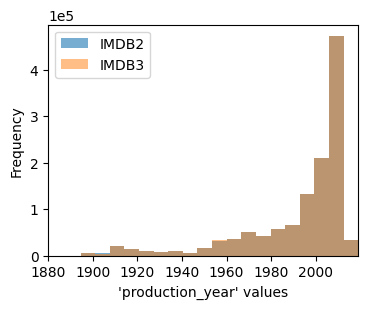

In [154]:
def distribution_plot(df1, df2, attr):
    fig, ax = plt.subplots(figsize=(4,3))
    _, bins, _ = ax.hist(df1[attr], bins=20, alpha=0.6, label=r'IMDB2')
    ax.hist(df2[attr], bins=bins, alpha=0.5, label=r'IMDB3')
    ax.legend()
    ax.set_xlim([min(df1[attr].min(), df2[attr].min()), max(df1[attr].max(), df2[attr].max())])
    ax.set_xlabel(f"'{attr}' values")
    ax.set_ylabel("Frequency")
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    plt.show()
    
distribution_plot(df_imdb2, df_imdb3, 'production_year')

### Check the cardinality of tables in IMDB2 and IMDB3

In [139]:
exec.close_connection()
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload')

Now connected to imdbload!


In [140]:
df_tables = exec.read_to_pandas("""
    SELECT table_name FROM information_schema.tables
        WHERE table_catalog = 'imdbload'
            AND table_schema = 'public'
""")
df_tables.head(3)

,table_name
0,cast_info
1,aka_title
2,char_name


In [141]:
data = []
for table in sorted(df_tables['table_name']):
    cardinality = exec.execute('SELECT COUNT(*) FROM ' + table).fetchall()[0][0]
    data.append({
        'table_name': table,
        'database_name': 'imdbload',
        'cardinality': cardinality
    })
    
df_imdb_stats = pd.DataFrame(data)
df_imdb_stats.head(3)

,table_name,database_name,cardinality
0,aka_name,imdbload,901343
1,aka_title,imdbload,361472
2,cast_info,imdbload,36244344


In [142]:
exec.close_connection()
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload2')

Now connected to imdbload2!


In [143]:
data = []
for table in sorted(df_tables['table_name']):
    cardinality = exec.execute('SELECT COUNT(*) FROM ' + table).fetchall()[0][0]
    data.append({
        'table_name': table,
        'database_name': 'imdbload2',
        'cardinality': cardinality
    })
    
df_imdb2_stats = pd.DataFrame(data)
df_imdb2_stats.head(3)

,table_name,database_name,cardinality
0,aka_name,imdbload2,901343
1,aka_title,imdbload2,361472
2,cast_info,imdbload2,18127150


In [144]:
exec.close_connection()
exec = PostgresExecutor.create_postgres_engine(db_name='imdbload3')

Now connected to imdbload3!


In [145]:
data = []
for table in sorted(df_tables['table_name']):
    cardinality = exec.execute('SELECT COUNT(*) FROM ' + table).fetchall()[0][0]
    data.append({
        'table_name': table,
        'database_name': 'imdbload3',
        'cardinality': cardinality
    })
    
df_imdb3_stats = pd.DataFrame(data)
df_imdb3_stats.head(3)

,table_name,database_name,cardinality
0,aka_name,imdbload3,901343
1,aka_title,imdbload3,361472
2,cast_info,imdbload3,18117183


In [150]:
df_cards = df_imdb2_stats.merge(df_imdb3_stats, left_on=['table_name'], right_on=['table_name'], suffixes=('_imdb2', '_imdb3')) \
    .merge(df_imdb_stats, left_on=['table_name'], right_on=['table_name'])

df_cards['diff'] = df_cards['cardinality_imdb3'] - df_cards['cardinality_imdb2']
df_cards['rel_diff'] = df_cards['diff'] / df_cards['cardinality_imdb2']
df_cards = df_cards.drop(columns=['database_name_imdb2', 'database_name_imdb3', 'database_name'])
df_cards = df_cards.sort_values(['table_name']).reset_index(drop=True)
df_cards = df_cards[['table_name', 'cardinality', 'cardinality_imdb2', 'cardinality_imdb3', 'diff', 'rel_diff']]
df_cards

,table_name,cardinality,cardinality_imdb2,cardinality_imdb3,diff,rel_diff
0,aka_name,901343,901343,901343,0,0.000000
1,aka_title,361472,361472,361472,0,0.000000
2,cast_info,36244344,18127150,18117183,-9967,-0.000550
3,char_name,3140339,3140339,3140339,0,0.000000
4,comp_cast_type,4,4,4,0,0.000000
5,company_name,234997,234997,234997,0,0.000000
6,company_type,4,4,4,0,0.000000
7,complete_cast,135086,67341,67745,404,0.005999
8,info_type,113,113,113,0,0.000000
9,keyword,134170,134170,134170,0,0.000000
